# Under-Representation Bias

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy

# Data + EDA

### Dataset Class

In [2]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = []):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.df = pd.read_csv(path, sep = ';')

### Popular Datasets

In [3]:
# each dataset is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        print("Error! Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

In [4]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country','income']
num_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols, num_cols)

add_dataset(adult_income)

# TODO - add more datasets

In [5]:
cat = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_mat", path='Datasets/student-mat.csv', cat_cols=cat, num_cols=num))
add_dataset(Dataset("student_por", path='Datasets/student-por.csv', cat_cols=cat, num_cols=num))

### EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [6]:
# take a peek at the first few data points
df_por = datasets['student_por'].df
# df_por.head()

In [7]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
# plot_counts(df_por, 'sex')

In [8]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
# group_by_plot(df_por, 'sex', 'G3')

In [9]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Preparation

### Problem Formulation

In [10]:
def threshold(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Added "pass/fail" to make problem binary classification
    """
    assert g_1 + g_2 + g_3 == 1, "The sum of the percentages should be 1"
    assert 0 < threshold < 20, "Threshold needs to be between 0 and 20"
    df['pass'] = df.apply(lambda row: 1
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
threshold(df_por, threshold=14)
# df_por['pass'].value_counts()

We will now ask you to identify potential sensitive/protected attributes. Run the chunk below to see the different features in the dataset.

In [11]:
sens_attrs = [df_por['sex'], df_por['address']]

### Data Preprocessing

In [12]:
# format data
X = df_por.iloc[:, :-2].values
y = df_por.iloc[:, -1].values

In [13]:
# OHE categorical features (prompt for user's choice here?)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols = get_cat_cols(datasets['student_por'])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [14]:
X_true = X
y_true = df_por['pass']
#X_bias = copy.deepcopy(X_true)
#y_bias = copy.deepcopy(y_true)

# Bias Injection

### Class Distribution Visualization

In [15]:
#df_por.shape
df_por['address'].value_counts()

U    452
R    197
Name: address, dtype: int64

<AxesSubplot:>

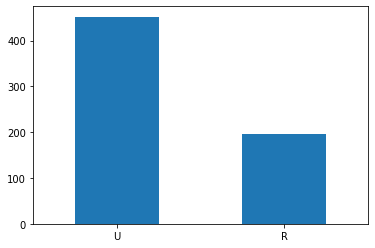

In [16]:
count = pd.value_counts(df_por['address'], sort = True)
count.plot(kind = 'bar', rot = 0)

### Bias Injection

In [17]:
# separate based on protected attribute
sens_values = sens_attrs[1].unique()

# TODO - add prompt for user to specify which value is favored and which is unfavored

df_favored = df_por[df_por['address'] == 'U']
df_unfavored = df_por[df_por['address'] == 'R']

In [18]:
# unfavored group with negative label
df_unfavored_negative = df_unfavored[df_unfavored['pass'] == 0]

# unfavored group with positive label (preferred)
df_unfavored_positive = df_unfavored[df_unfavored['pass'] == 1]

# differences in label counts for unfavored group
df_unfavored['pass'].value_counts()

df_total = pd.concat([df_favored, df_unfavored_negative])

print(len(df_unfavored_positive))
print(len(df_unfavored_negative))
#len(df_total)

31
166


### Under-Sampling Process

In [19]:
# under-sampling process
df_undersampled = df_unfavored_positive.sample(n=31, random_state=42)

#print(df_favored.shape, df_unfavored.shape, df_undersampled.shape)

# combine undersampled and original favored class to create dataset
df_concat = pd.concat([df_total,df_undersampled])
#print(df_concat.shape)

# for fairness measures later
df_sens = df_concat['address']

# format data
X_bias = df_concat.iloc[:, :-2].values
#print(X_undersampled.shape)
y_bias = df_concat.iloc[:, -1].values

# OHE
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X_bias_true = np.array(ct.fit_transform(X_bias))
y_bias_true = df_concat['pass']

#print(X_true.shape, X_bias_true.shape)
#print(y_true.value_counts(), "\n\n", y_bias_true.value_counts())


### Post-Injection Visualization

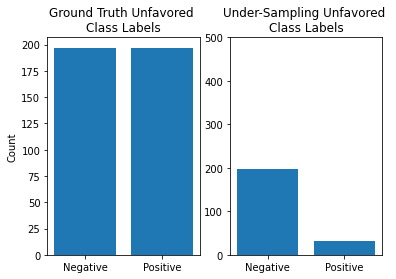

In [20]:
positive = len(df_unfavored['pass'] == 0)
true_positive = len(df_unfavored['pass'] == 1)
bias_positive = len(df_undersampled)

x_vals = ['Negative', "Positive"]
y_vals_true = [positive, true_positive]
y_vals_bias = [positive, bias_positive]

plt.subplot(1,2,1)
plt.bar(x_vals, y_vals_true)
plt.title("Ground Truth Unfavored \nClass Labels")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.bar(x_vals, y_vals_bias)
plt.title("Under-Sampling Unfavored \nClass Labels")
plt.ylim([0,500])

plt.show()

# Model

### Model Selection + Training (TODO: modularize)

In [21]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_bias_true, y_bias_true)
y_pred_bias = classifier_bias.predict(X_bias_true)
y_pred_bias_on_true = classifier_bias.predict(X_true)

### Model Performance (TODO: modularize)

In [22]:
print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_pred_truth, y_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Accuracy of Ground Truth Model on Ground Truth Data:  0.9845916795069337
Accuracy of Biased Model on Biased Data:  0.9845916795069337
Accuracy of Biased Model on Ground Truth Data:  0.9845916795069337


Thus, we can see that under-sampling decreases model performance on the ground truth data.

In [23]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(accuracy_score, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(selection_rate, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Overall Accuracy:  0.9845916795069337
Group Accuracy :  address
R    0.979695
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2110939907550077
Group Selection Rate :  address
R    0.177665
U    0.225664
Name: selection_rate, dtype: object


Thus, we can see that there is a **5% discrepancy** in the selection rate for Rural vs Urban students (with Urban students being preferred)

In [24]:
# Biased Model on Biased Data

gm_bias = MetricFrame(accuracy_score, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Accuracy: ", gm_bias.overall)
print("Group Accuracy : ", gm_bias.by_group)

print("\n")

sr_bias = MetricFrame(selection_rate, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Selection Rate: ", sr_bias.overall)
print("Group Selection Rate : ", sr_bias.by_group)

Overall Accuracy:  0.9845916795069337
Group Accuracy :  address
R    0.979695
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2110939907550077
Group Selection Rate :  address
R    0.177665
U    0.225664
Name: selection_rate, dtype: object


Thus, we can see that there is now a **7% discrepancy due to under-sampling** in the selection rate for Rural vs Urban students (with Urban students being preferred) on biased data

In [25]:
# Biased Model on Ground Truth Data

gm_bias_on_true = MetricFrame(accuracy_score, y_true,
                           y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_bias_on_true.overall)
print("Group Accuracy : ", gm_bias_on_true.by_group)

print("\n")

sr_bias_on_true = MetricFrame(selection_rate, y_true,
                              y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_bias_on_true.overall)
print("Group Selection Rate : ", sr_bias_on_true.by_group)

Overall Accuracy:  0.9845916795069337
Group Accuracy :  address
R    0.979695
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2110939907550077
Group Selection Rate :  address
R    0.177665
U    0.225664
Name: selection_rate, dtype: object


Thus, we see that the biased model has lower overall and subgroup accuracy on the ground truth data. 
Also, we can observe that the selection rate disparity increased ever so slightly with the biased model.

In [26]:
print("Ground Truth Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("\n")

print("Biased Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

Ground Truth Model on Ground Truth Data
EOD: 0.047169811320754707
DPD: 0.04799874219486994
EOR: 0.11994219653179189
DPR: 0.7872996914501842


Biased Model on Ground Truth Data
EOD: 0.047169811320754707
DPD: 0.04799874219486994
EOR: 0.11994219653179189
DPR: 0.7872996914501842


# Fairness Intervention

In [27]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
np.random.seed(0)

In [28]:
constraint = EqualizedOdds()
mitigator_true = ExponentiatedGradient(classifier_true, constraint)
mitigator_true.fit(X_true, y_true, sensitive_features = sens_attrs[1])
y_pred_mitigated_true = mitigator_true.predict(X_true)

In [29]:
constraint = EqualizedOdds()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
y_pred_mitigated_bias = mitigator_bias.predict(X_bias_true)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

# Evaluation

In [30]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

In [31]:
print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_true, y_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.9799691833590138
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.9768875192604006


In [32]:
# Ground Truth Model + Fairness Intervention on Ground Truth Data

gm_mitigated = MetricFrame(accuracy_score, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print("\n")

sr_mitigated = MetricFrame(selection_rate, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Accuracy:  0.9799691833590138
Group Accuracy :  address
R    0.974619
U    0.982301
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.21263482280431434
Group Selection Rate :  address
R    0.172589
U    0.230088
Name: selection_rate, dtype: object


In [33]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(accuracy_score, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(selection_rate, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

Overall Accuracy:  0.9768875192604006
Group Accuracy :  address
R    0.964467
U    0.982301
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2218798151001541
Group Selection Rate :  address
R    0.192893
U    0.234513
Name: selection_rate, dtype: object


Hence, we observe an increase in overall and subgroup accuracy, but a decrease in disadvantaged subgroup selection rate

### Bias vs Accuracy vs Fairness Trade-Off

In [34]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(classifier, apply_fairness = False, verbose = False):
    
    bias_amts = list(range(0,30))
    accuracy_on_true = []
    accuracy_on_biased = []
    eod_on_true = []
    eod_on_biased = []
    dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
    dataset_size_bias = []
    table = []

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    df_undersampled = df_unfavored_positive.sample(n=len(df_unfavored_positive), random_state=42)

    for i in range(30):
        # under-sampling process
        if i == 0:
            df_undersampled = df_undersampled.sample(n=len(df_undersampled), random_state=42)
        else:
            df_undersampled = df_undersampled.sample(n=len(df_undersampled)-1, random_state=42)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_favored,df_undersampled])
        df_concat.shape
        df_sens = df_concat['address']

        # format data
        X_bias = df_concat.iloc[:, :-2].values
        y_bias = df_concat.iloc[:, -1].values

        # OHE
        ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
        X_bias_true = np.array(ct.fit_transform(X_bias))
        y_bias_true = df_concat['pass']

        dataset_size_bias.append(X_bias_true.shape[0])
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
            mitigator_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            y_pred_bias = classifier_bias.predict(X_bias_true)
            y_pred_bias_on_true = mitigator_bias.predict(X_true)
        
        else:
            y_pred_bias = classifier_bias.predict(X_bias_true)
            y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)

        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)

        # fairness performance
        eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
        eod_on_true.append(eod_true)

        eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
        eod_on_biased.append(eod_bias_on_true)

        # table visualization 
        table_elem = [i*10, acc_bias, acc_bias_on_true]
        table.append(table_elem)
        
        if verbose:
            print("Finished Iteration: ", len(df_concat))

    return bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true

In [35]:
def visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true, fairness = False):
    
    if not fairness:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()
    else:
        
        plt.plot(bias_amts, eod_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, eod_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Equalized Odds Difference")
        plt.axhline(y=equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]), color = "green",
                    label = "Ground Truth EOD", alpha = 0.5)
        plt.legend()
        plt.title("Biased Model Equalized Odds Difference")
        plt.show()
        #plt.savefig("bias1.png")

In [36]:
bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true = tradeoff_visualization(classifier, False, False)

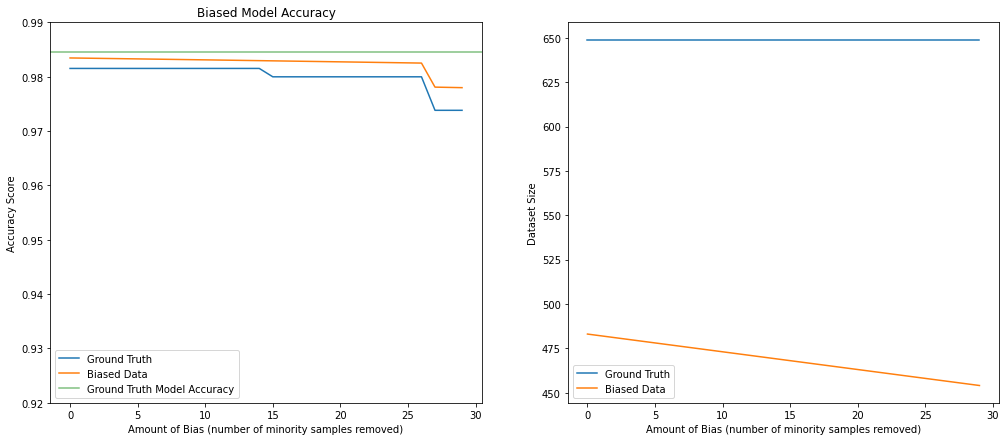

In [37]:
visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true, False)

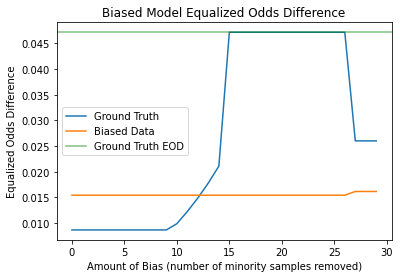

In [38]:
visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true, True)

In [39]:
bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true = tradeoff_visualization(classifier, True, False)

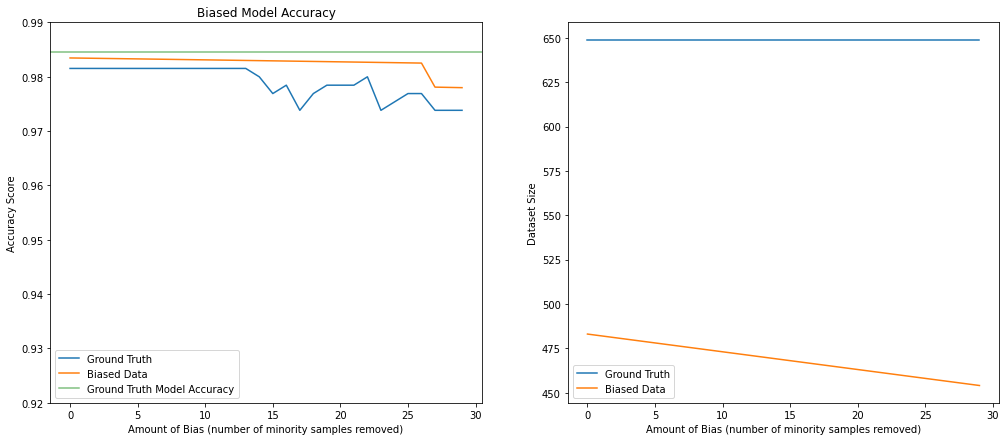

In [40]:
visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true, False)

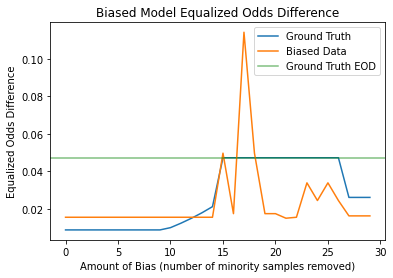

In [41]:
visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true, True)

### Special Visualizations

In [42]:
bias_amts = list(range(0,30))
accuracy_on_true = []
accuracy_on_biased = []
accuracy_on_true_mitigated = []
eod_on_true = []
eod_on_biased = []
eod_on_true_mitigated = []
dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
dataset_size_bias = []
table = []

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

df_undersampled = df_unfavored_positive.sample(n=len(df_unfavored_positive), random_state=42)

for i in range(30):
    # under-sampling process
    print(len(df_undersampled))
    if i == 0:
        df_undersampled = df_undersampled.sample(n=len(df_undersampled), random_state=42)
    else:
        df_undersampled = df_undersampled.sample(n=len(df_undersampled)-1, random_state=42)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_favored,df_undersampled])

    df_sens = df_concat['address']

    # format data
    X_bias = df_concat.iloc[:, :-2].values
    y_bias = df_concat.iloc[:, -1].values

    # OHE
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
    X_bias_true = np.array(ct.fit_transform(X_bias))
    y_bias_true = df_concat['pass']

    dataset_size_bias.append(X_bias_true.shape[0])
    classifier_bias = classifier.fit(X_bias_true, y_bias_true)

    constraint = EqualizedOdds()
    #constraint = DemographicParity()
    
    mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
    mitigator_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
    y_pred_mitigated_bias = classifier_bias.predict(X_bias_true)
    y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

    y_pred_bias = classifier_bias.predict(X_bias_true)
    y_pred_bias_on_true = classifier_bias.predict(X_true)

    # model performance
    acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
    accuracy_on_biased.append(acc_bias)

    acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
    accuracy_on_true.append(acc_bias_on_true)
    
    acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
    accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)

    # fairness performance
    eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
    eod_on_true.append(eod_true)

    eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
    eod_on_biased.append(eod_bias_on_true)
    
    eod_bias_true_mitigated = equalized_odds_difference(y_true=y_true, y_pred = y_pred_mitigated_bias_on_true, sensitive_features=sens_attrs[1])
    eod_on_true_mitigated.append(eod_bias_true_mitigated)


31
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3


In [43]:
bias_amts = list(range(0,30))
accuracy_on_true = []
accuracy_on_biased = []
accuracy_on_true_mitigated = []
eod_on_true = []
eod_on_biased = []
eod_on_true_mitigated = []
dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
dataset_size_bias = []
table = []

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

df_undersampled = df_unfavored_positive.sample(n=len(df_unfavored_positive), random_state=42)

for i in range(30):
    # under-sampling process
    print(len(df_undersampled))
    if i == 0:
        df_undersampled = df_undersampled.sample(n=len(df_undersampled), random_state=42)
    else:
        df_undersampled = df_undersampled.sample(n=len(df_undersampled)-1, random_state=42)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_favored,df_undersampled])
    df_concat.shape
    df_sens = df_concat['address']

    # format data
    X_bias = df_concat.iloc[:, :-2].values
    y_bias = df_concat.iloc[:, -1].values

    # OHE
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
    X_bias_true = np.array(ct.fit_transform(X_bias))
    y_bias_true = df_concat['pass']

    dataset_size_bias.append(X_bias_true.shape[0])
    classifier_bias = classifier.fit(X_bias_true, y_bias_true)

    constraint = EqualizedOdds()
    #constraint =DemographicParitymographicParity()
    
    mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
    mitigator_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
    y_pred_mitigated_bias = classifier_bias.predict(X_bias_true)
    y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

    y_pred_bias = classifier_bias.predict(X_bias_true)
    y_pred_bias_on_true = classifier_bias.predict(X_true)

    # model performance
    acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
    accuracy_on_biased.append(acc_bias)

    acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
    accuracy_on_true.append(acc_bias_on_true)
    
    acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
    accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)

    # fairness performance
    eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
    eod_on_true.append(eod_true)

    eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
    eod_on_biased.append(eod_bias_on_true)
    
    eod_bias_true_mitigated = equalized_odds_difference(y_true=y_true, y_pred = y_pred_mitigated_bias_on_true, sensitive_features=sens_attrs[1])
    eod_on_true_mitigated.append(eod_bias_true_mitigated)

31
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3


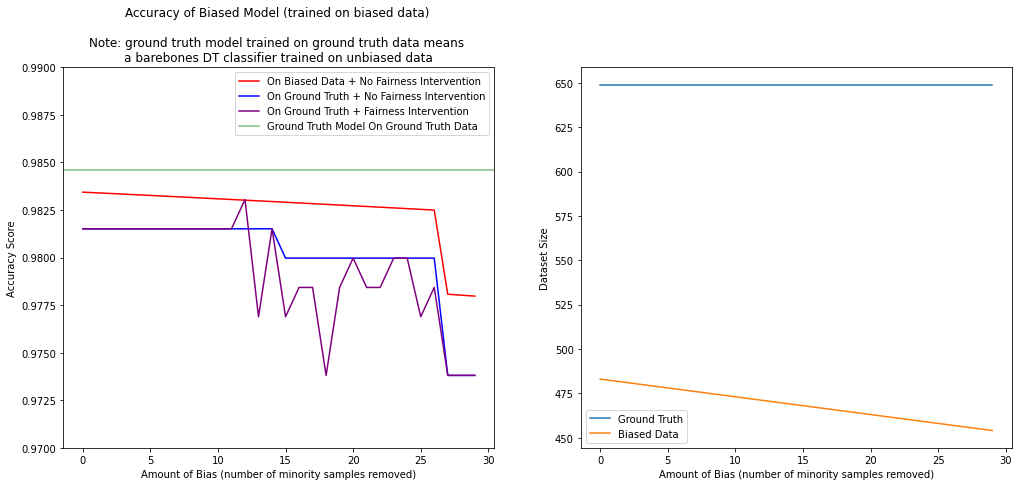

In [44]:
plt.figure(figsize=(17,7))

plt.subplot(1,2,1)
plt.plot(bias_amts, accuracy_on_biased, label = 'On Biased Data + No Fairness Intervention', color = "red")
plt.plot(bias_amts, accuracy_on_true, label = 'On Ground Truth + No Fairness Intervention', color = "blue")
plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'On Ground Truth + Fairness Intervention', color = "purple")
plt.xlabel("Amount of Bias (number of minority samples removed)")
plt.ylabel("Accuracy Score")
plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
plt.title("Accuracy of Biased Model (trained on biased data) \n\nNote: ground truth model trained on ground truth data means \na barebones DT classifier trained on unbiased data")
plt.ylim(0.97, 0.99)
plt.legend()

plt.subplot(1,2,2)
plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
plt.xlabel("Amount of Bias (number of minority samples removed)")
plt.ylabel("Dataset Size")
plt.legend()

plt.show()

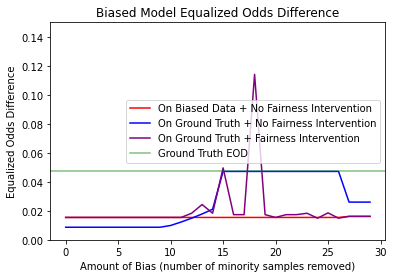

In [45]:
plt.plot(bias_amts, eod_on_biased, label = 'On Biased Data + No Fairness Intervention', color = "red")
plt.plot(bias_amts, eod_on_true, label = 'On Ground Truth + No Fairness Intervention', color = "blue")
plt.plot(bias_amts, eod_on_true_mitigated, label = 'On Ground Truth + Fairness Intervention', color = "purple")
plt.xlabel("Amount of Bias (number of minority samples removed)")
plt.ylabel("Equalized Odds Difference")
plt.axhline(y=equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]), color = "green",
            label = "Ground Truth EOD", alpha = 0.5)
plt.ylim(0, 0.15)
plt.legend()
plt.title("Biased Model Equalized Odds Difference")
plt.show()
#plt.savefig("bias1.png")